In [1]:
import os
import random
import networkx as nx
import numpy as np
import gymnasium as gym
from gymnasium.spaces import Discrete, Box
from typing import Optional, Dict, Any, Tuple
from ray.rllib.env.multi_agent_env import MultiAgentEnv
import pickle
import matplotlib.pyplot as plt
from collections import namedtuple



# Network partitions and system states
NETWORK_PARTITIONS = ["Contractor Network",
                      "Deployed Network A", "Operational Zone A", "Restricted Zone A",
                      "Deployed Network B", "Operational Zone B", "Restricted Zone B",
                      "Headquarters Network", "Public Access Zone", "Office Network", "Admin Network"]

STATE_UNKNOWN = 2
STATE_COMPROMISED = 1
STATE_SAFE = 0

# Network status dictionary
network_status = {
    "Contractor Network": 1,
    "Deployed Network A": 1,
    "Deployed Network B": 1,
    "Headquarters Network": 1
}

# Reward mapping for zones
ZONE_REWARDS = {
    "Headquarters Network": {
        "Local Work Fails": -1,
        "Access Service Fails": -1, 
        "Red Impact/Access": -3,
        "Access Control": -1,
        "Server Compromise": -1
    },
    "Public Access Zone": {
        "Local Work Fails": -1,
        "Access Service Fails": -1,
        "Red Impact/Access": -3,
        "Access Control": -1,
        "Server Compromise": -1
    },
    "Office Network": {
        "Local Work Fails": -1,
        "Access Service Fails": -1,
        "Red Impact/Access": -3,
        "Access Control": -1,
        "Server Compromise": -1
    },
    "Admin Network": {
        "Local Work Fails": -1,
        "Access Service Fails": -1,
        "Red Impact/Access": -3,
        "Access Control": -1,
        "Server Compromise": -1
    },
    "Contractor Network": {
        "Local Work Fails": 0,
        "Access Service Fails": 0,
        "Red Impact/Access": 0,
        "Access Control": 0,
        "Server Compromise": 0
    },
    "Restricted Zone A": {
        "Local Work Fails": -1,
        "Access Service Fails": -3,
        "Red Impact/Access": -1,
        "Access Control": -1,
        "Server Compromise": -1
    },
    "Operational Zone A": {
        "Local Work Fails": -1,
        "Access Service Fails": -1,
        "Red Impact/Access": -1,
        "Access Control": -1,
        "Server Compromise": -1
    },
    "Restricted Zone B": {
        "Local Work Fails": -1,
        "Access Service Fails": -3,
        "Red Impact/Access": -1,
        "Access Control": -1,
        "Server Compromise": -1
    },
    "Operational Zone B": {
        "Local Work Fails": -1,
        "Access Service Fails": -1,
        "Red Impact/Access": -1,
        "Access Control": -1,
        "Server Compromise": -1
    }
}

class Agent:
    def __init__(self, agent_id, network_zone):
        self.access_control = False
        self.agent_id = agent_id
        self.network_zone = network_zone
        self.compromised = False
        self.receive_buffer = []  # List for tracking incoming messages

    def get_id(self):
        return self.agent_id

class GreenAgent(Agent):
    def __init__(self, agent_id, network_zone, security_risk):
        super().__init__(agent_id, network_zone)
        self.action_list = ["Local work", "Open email", "Transfer Information"]
        self.security_risk = security_risk  # Probability of compromise when opening email

    def open_email(self):
        """
        Attempt to open an email. The email may be malicious based on the agent's security risk.
        If malicious, mark the agent as compromised.
        """
        is_malicious = random.random() < self.security_risk
        if is_malicious:
            self.compromised = True
            return f"{self.agent_id} opened a malicious email and was compromised."
        return f"{self.agent_id} opened an email safely."

    def perform_local_work(self):
        return f"{self.agent_id} is performing local work."

    def schedule_transfer(self, target_agent, distance):
        if distance == float('inf'):
            # Retrieve the "Access Service Fails" reward from ZONE_REWARDS based on the agent's network zone
            zone_reward = ZONE_REWARDS.get(self.network_zone, {})
            reward = zone_reward.get("Access Service Fails", 0)
            return f"{self.agent_id} failed to transfer information to {target_agent.agent_id} due to no path.", reward
        else:
            # Include the sender's compromised status at the time of sending
            message = {
                'sender': self.agent_id,
                'sender_compromised': self.compromised,
                'delay': distance
            }
            target_agent.receive_buffer.append(message)
            return f"{self.agent_id} scheduled information transfer to {target_agent.agent_id} after {distance} timesteps.", None

class RedAgent(Agent):
    """
    An attacker agent capable of infecting multiple targets based on configurable parameters 
    such as focus network, infection size, and success rate.
    """
    def __init__(self, focus_network, infection_size, success_rate):
        super().__init__("RedAgent", "Contractor Network")
        self.focus_network = focus_network.upper()     # "A", "B", "HQ", or "RANDOM"
        self.infection_size = infection_size           # how many total entities can be compromised in one action
        self.success_rate = success_rate
        self.positions = []  # compromised green agents serving as infiltration points
        self.action_list = ["Infect", "Sleep"]

        
    def add_position(self, compromised_agent):
        if compromised_agent not in self.positions:
            self.positions.append(compromised_agent)

    def _servers_in_same_subnet(self, env, compromised_point):
        """
        Return servers in the same zone as compromised_point.network_zone
        that are not yet compromised.
        """
        same_zone = compromised_point.network_zone
        return [
            s for s in env.servers.values()
            if s.network_zone == same_zone and not s.compromised
        ]

    def _filter_green_agents_by_focus(self, env):
        """
        Return a list of un-compromised, no-access-control green agents
        in the focus zone. If RANDOM, it's any un-compromised green agent.
        """
        all_gas = env.green_agents.values()
        if self.focus_network == "A":
            return [
                ga for ga in all_gas
                if ("Deployed Network A" in ga.network_zone) and not ga.compromised and not ga.access_control
            ]
        elif self.focus_network == "B":
            return [
                ga for ga in all_gas
                if ("Deployed Network B" in ga.network_zone) and not ga.compromised and not ga.access_control
            ]
        elif self.focus_network == "HQ":
            hq_zones = ["Headquarters Network", "Public Access Zone", "Office Network", "Admin Network"]
            return [
                ga for ga in all_gas
                if ga.network_zone in hq_zones and not ga.compromised and not ga.access_control
            ]
        else:
            # RANDOM => no zone filter
            return [ga for ga in all_gas if not ga.compromised and not ga.access_control]

    def perform_infection(self, env, dist_dict):
        """
        Infect up to `infection_size` total entities. For each infiltration point:
            - We gather all servers in the same zone (not compromised).
            - We gather all green agents in the focus zone (uncompromised, no access_control).
            - Then we unify that list and randomly pick up to infection_size total from them.

        Returns the total reward from this infection step.
        """
        if not self.positions:
            return 0.0  # no infiltration => no infection

        # Collect all possible servers from each infiltration zone
        possible_servers = []
        for compromised_point in self.positions:
            local_servers = self._servers_in_same_subnet(env, compromised_point)
            possible_servers.extend(local_servers)
        # De-dup servers if multiple infiltration points share the same zone
        possible_servers = list({s.server_id: s for s in possible_servers}.values())

        # Collect green agents in focus zone
        possible_green = self._filter_green_agents_by_focus(env)

        # Union => these are potential victims
        union_targets = list(possible_servers) + list(possible_green)
        if not union_targets:
            return 0.0

        # Pick up to infection_size
        chosen = random.sample(union_targets, min(self.infection_size, len(union_targets)))

        infection_reward = 0.0
        for target in chosen:
            if isinstance(target, Server):
                # Only compromise if random < success_rate
                if random.random() < self.success_rate:
                    target.compromised = True
                    zone_reward = ZONE_REWARDS.get(target.network_zone, {})
                    infection_reward += zone_reward.get("Server Compromise", 0)
            else:
                # target is a GreenAgent => check path from infiltration point
                # pick any infiltration point, or you can pick randomly among positions
                sender = random.choice(self.positions)
                dist = dist_dict.get(sender.agent_id, {}).get(target.agent_id, float('inf'))
                if dist == float('inf'):
                    # path blocked => "Access Service Fails" from sender's zone
                    zone_reward = ZONE_REWARDS.get(sender.network_zone, {})
                    infection_reward += 0
                else:
                    # Infect target (if no decoy)
                    decoy_active = any(target.agent_id in b.decoy_targets for b in env.blue_agents.values())
                    if not decoy_active and not target.compromised:
                        target.compromised = True
                        self.add_position(target)  # new infiltration point
                        zone_reward = ZONE_REWARDS.get(target.network_zone, {})
                        infection_reward += zone_reward.get("Red Impact/Access", 0)

        return infection_reward

class NoAttackRedAgent(RedAgent):
    def __init__(self, **kwargs):
        # No infection functionality; dummy values for focus and infection_size.
        super().__init__(focus_network="NONE", infection_size=0, success_rate=0)
        self.type_id = 0  # For observation encoding
    def perform_infection(self, env, dist_dict):
        # This attacker does not infect new targets.
        return 0.0


class AllSubnetAttacker(RedAgent):
    def __init__(self, success_rate, **kwargs):
        # Dummy values since custom logic will be used.
        super().__init__(focus_network="ALL", infection_size=1, success_rate=success_rate)
        self.type_id = 1
        # Define the target subnets: four fixed plus one HQ (randomly chosen later)
        self.target_subnets = ["Operational Zone A", "Restricted Zone A", "Operational Zone B", "Restricted Zone B"]
        self.hq_options = ["Public Access Zone", "Office Network", "Admin Network"]

    def perform_infection(self, env, dist_dict):
        infection_reward = 0.0
        # For each target subnet:
        for subnet in self.target_subnets:
            available_green = [ga for ga in env.green_agents.values()
                               if ga.network_zone == subnet and not ga.compromised and not ga.access_control]
            available_servers = [sv for sv in env.servers.values()
                                 if sv.network_zone == subnet and not sv.compromised]
            if self.infection_size == 1:
                candidates = available_green + available_servers
                if candidates:
                    target = random.choice(candidates)
                    if isinstance(target, Server):
                        if random.random() < self.success_rate:
                            target.compromised = True
                            reward = ZONE_REWARDS.get(target.network_zone, {}).get("Server Compromise", 0)
                            infection_reward += reward
                    else:
                        target.compromised = True
                        self.add_position(target)
                        reward = ZONE_REWARDS.get(target.network_zone, {}).get("Red Impact/Access", 0)
                        infection_reward += reward
            else:
                # If infection size >=2, try to pick one green and one server.
                if available_green and available_servers:
                    target_green = random.choice(available_green)
                    target_green.compromised = True
                    self.add_position(target_green)
                    reward = ZONE_REWARDS.get(target_green.network_zone, {}).get("Red Impact/Access", 0)
                    infection_reward += reward

                    target_server = random.choice(available_servers)
                    if random.random() < self.success_rate:
                        target_server.compromised = True
                        reward = ZONE_REWARDS.get(target_server.network_zone, {}).get("Server Compromise", 0)
                        infection_reward += reward
                else:
                    candidates = available_green + available_servers
                    if candidates:
                        target = random.choice(candidates)
                        if isinstance(target, Server):
                            if random.random() < self.success_rate:
                                target.compromised = True
                                reward = ZONE_REWARDS.get(target.network_zone, {}).get("Server Compromise", 0)
                                infection_reward += reward
                        else:
                            target.compromised = True
                            self.add_position(target)
                            reward = ZONE_REWARDS.get(target.network_zone, {}).get("Red Impact/Access", 0)
                            infection_reward += reward

        # For the HQ subnet:
        hq_zone = random.choice(self.hq_options)
        available_green = [ga for ga in env.green_agents.values()
                           if ga.network_zone == hq_zone and not ga.compromised and not ga.access_control]
        available_servers = [sv for sv in env.servers.values()
                             if sv.network_zone == hq_zone and not sv.compromised]
        if self.infection_size == 1:
            candidates = available_green + available_servers
            if candidates:
                target = random.choice(candidates)
                if isinstance(target, Server):
                    if random.random() < self.success_rate:
                        target.compromised = True
                        reward = ZONE_REWARDS.get(target.network_zone, {}).get("Server Compromise", 0)
                        infection_reward += reward
                else:
                    target.compromised = True
                    self.add_position(target)
                    reward = ZONE_REWARDS.get(target.network_zone, {}).get("Red Impact/Access", 0)
                    infection_reward += reward
        else:
            if available_green and available_servers:
                target_green = random.choice(available_green)
                target_green.compromised = True
                self.add_position(target_green)
                reward = ZONE_REWARDS.get(target_green.network_zone, {}).get("Red Impact/Access", 0)
                infection_reward += reward

                target_server = random.choice(available_servers)
                if random.random() < self.success_rate:
                    target_server.compromised = True
                    reward = ZONE_REWARDS.get(target_server.network_zone, {}).get("Server Compromise", 0)
                    infection_reward += reward
            else:
                candidates = available_green + available_servers
                if candidates:
                    target = random.choice(candidates)
                    if isinstance(target, Server):
                        if random.random() < self.success_rate:
                            target.compromised = True
                            reward = ZONE_REWARDS.get(target.network_zone, {}).get("Server Compromise", 0)
                            infection_reward += reward
                    else:
                        target.compromised = True
                        self.add_position(target)
                        reward = ZONE_REWARDS.get(target.network_zone, {}).get("Red Impact/Access", 0)
                        infection_reward += reward

        return infection_reward


class SpecificSubnetAttacker(RedAgent):
    def __init__(self, success_rate, **kwargs):
        # Focus solely on Operational Zone A with 2 infections.
        super().__init__(focus_network="Operational Zone A", infection_size=2, success_rate=success_rate)
        self.type_id = 2

    def perform_infection(self, env, dist_dict):
        infection_reward = 0.0
        available_green = [ga for ga in env.green_agents.values()
                           if ga.network_zone == "Operational Zone A" and not ga.compromised and not ga.access_control]
        available_servers = [sv for sv in env.servers.values()
                             if sv.network_zone == "Operational Zone A" and not sv.compromised]
        if self.infection_size == 1:
            candidates = available_green + available_servers
            if candidates:
                target = random.choice(candidates)
                if isinstance(target, Server):
                    if random.random() < self.success_rate:
                        target.compromised = True
                        reward = ZONE_REWARDS.get(target.network_zone, {}).get("Server Compromise", 0)
                        infection_reward += reward
                else:
                    target.compromised = True
                    self.add_position(target)
                    reward = ZONE_REWARDS.get(target.network_zone, {}).get("Red Impact/Access", 0)
                    infection_reward += reward
        else:
            # If both types are available, try to infect one of each.
            if available_green and available_servers:
                target_green = random.choice(available_green)
                target_green.compromised = True
                self.add_position(target_green)
                reward = ZONE_REWARDS.get(target_green.network_zone, {}).get("Red Impact/Access", 0)
                infection_reward += reward

                target_server = random.choice(available_servers)
                if random.random() < self.success_rate:
                    target_server.compromised = True
                    reward = ZONE_REWARDS.get(target_server.network_zone, {}).get("Server Compromise", 0)
                    infection_reward += reward
            else:
                candidates = available_green + available_servers
                if candidates:
                    target = random.choice(candidates)
                    if isinstance(target, Server):
                        if random.random() < self.success_rate:
                            target.compromised = True
                            reward = ZONE_REWARDS.get(target.network_zone, {}).get("Server Compromise", 0)
                            infection_reward += reward
                    else:
                        target.compromised = True
                        self.add_position(target)
                        reward = ZONE_REWARDS.get(target.network_zone, {}).get("Red Impact/Access", 0)
                        infection_reward += reward
        return infection_reward

class TimeDependentAllSubnetAttacker(RedAgent):
    def __init__(self, success_rate, **kwargs):
        super().__init__(focus_network="ALL", infection_size=1, success_rate=success_rate)
        self.type_id = 3
        self.target_subnets = ["Operational Zone A", "Restricted Zone A", "Operational Zone B", "Restricted Zone B"]
        self.hq_options = ["Public Access Zone", "Office Network", "Admin Network"]

    def perform_infection(self, env, dist_dict):
        if env.step_count % 3 != 0:
            return 0.0
        infection_reward = 0.0
        # For each target subnet:
        for subnet in self.target_subnets:
            available_green = [ga for ga in env.green_agents.values()
                               if ga.network_zone == subnet and not ga.compromised and not ga.access_control]
            available_servers = [sv for sv in env.servers.values()
                                 if sv.network_zone == subnet and not sv.compromised]
            if self.infection_size == 1:
                candidates = available_green + available_servers
                if candidates:
                    target = random.choice(candidates)
                    if isinstance(target, Server):
                        if random.random() < self.success_rate:
                            target.compromised = True
                            reward = ZONE_REWARDS.get(target.network_zone, {}).get("Server Compromise", 0)
                            infection_reward += reward
                    else:
                        target.compromised = True
                        self.add_position(target)
                        reward = ZONE_REWARDS.get(target.network_zone, {}).get("Red Impact/Access", 0)
                        infection_reward += reward
            else:
                if available_green and available_servers:
                    target_green = random.choice(available_green)
                    target_green.compromised = True
                    self.add_position(target_green)
                    reward = ZONE_REWARDS.get(target_green.network_zone, {}).get("Red Impact/Access", 0)
                    infection_reward += reward

                    target_server = random.choice(available_servers)
                    if random.random() < self.success_rate:
                        target_server.compromised = True
                        reward = ZONE_REWARDS.get(target_server.network_zone, {}).get("Server Compromise", 0)
                        infection_reward += reward
                else:
                    candidates = available_green + available_servers
                    if candidates:
                        target = random.choice(candidates)
                        if isinstance(target, Server):
                            if random.random() < self.success_rate:
                                target.compromised = True
                                reward = ZONE_REWARDS.get(target.network_zone, {}).get("Server Compromise", 0)
                                infection_reward += reward
                        else:
                            target.compromised = True
                            self.add_position(target)
                            reward = ZONE_REWARDS.get(target.network_zone, {}).get("Red Impact/Access", 0)
                            infection_reward += reward

        # HQ part:
        hq_zone = random.choice(self.hq_options)
        available_green = [ga for ga in env.green_agents.values()
                           if ga.network_zone == hq_zone and not ga.compromised and not ga.access_control]
        available_servers = [sv for sv in env.servers.values()
                             if sv.network_zone == hq_zone and not sv.compromised]
        if self.infection_size == 1:
            candidates = available_green + available_servers
            if candidates:
                target = random.choice(candidates)
                if isinstance(target, Server):
                    if random.random() < self.success_rate:
                        target.compromised = True
                        reward = ZONE_REWARDS.get(target.network_zone, {}).get("Server Compromise", 0)
                        infection_reward += reward
                else:
                    target.compromised = True
                    self.add_position(target)
                    reward = ZONE_REWARDS.get(target.network_zone, {}).get("Red Impact/Access", 0)
                    infection_reward += reward
        else:
            if available_green and available_servers:
                target_green = random.choice(available_green)
                target_green.compromised = True
                self.add_position(target_green)
                reward = ZONE_REWARDS.get(target_green.network_zone, {}).get("Red Impact/Access", 0)
                infection_reward += reward

                target_server = random.choice(available_servers)
                if random.random() < self.success_rate:
                    target_server.compromised = True
                    reward = ZONE_REWARDS.get(target_server.network_zone, {}).get("Server Compromise", 0)
                    infection_reward += reward
            else:
                candidates = available_green + available_servers
                if candidates:
                    target = random.choice(candidates)
                    if isinstance(target, Server):
                        if random.random() < self.success_rate:
                            target.compromised = True
                            reward = ZONE_REWARDS.get(target.network_zone, {}).get("Server Compromise", 0)
                            infection_reward += reward
                    else:
                        target.compromised = True
                        self.add_position(target)
                        reward = ZONE_REWARDS.get(target.network_zone, {}).get("Red Impact/Access", 0)
                        infection_reward += reward

        return infection_reward

        
BlueAction = namedtuple("BlueAction", ["action_type", "targets"])

# Enumerate possible action types:
MONITOR = "MONITOR"
REBOOT = "REBOOT"
DEPLOY_DECOY = "DEPLOY_DECOY"
ENABLE_AC = "ENABLE_AC"
DISABLE_AC = "DISABLE_AC"
ENABLE_SUBNET_AC = "ENABLE_SUBNET_AC"
DISABLE_SUBNET_AC = "DISABLE_SUBNET_AC"

class BlueAgent(Agent):
    def __init__(self, agent_id, network_zone, subnet_type, num_green_agents=3, num_servers=3):
        super().__init__(agent_id, network_zone)
        self.num_green_agents = num_green_agents
        self.num_servers = num_servers
        self.reboot_limit = 2
        self.subnet_type = subnet_type
        self.action_mapping = self._create_action_mapping()
        self.decoy_targets = {}
        self.observation_order = self._get_observation_order()

    def _get_observation_order(self):
        if self.subnet_type == "Headquarters":
            # Observation order for HQ defender
            observation_order = []
            zones = ["Public Access Zone", "Office Network", "Admin Network"]
            for zone in zones:
                for i in range(self.num_green_agents):
                    observation_order.append(f"GreenAgent-{zone}-{i+1}")
                for i in range(self.num_servers):
                    observation_order.append(f"Server-{zone}-{i+1}")
            return observation_order
        else:
            # Observation order for deployed networks
            observation_order = []
            for i in range(self.num_green_agents):
                observation_order.append(f"GreenAgent-{self.network_zone}-{i+1}")
            for i in range(self.num_servers):
                observation_order.append(f"Server-{self.network_zone}-{i+1}")
            return observation_order

    def _create_action_mapping(self):
        actions = self.action_space()
        action_mapping = {i: action for i, action in enumerate(actions)}
        return action_mapping

    def monitor(self):
        return f"{self.agent_id} is monitoring the {self.network_zone}."

    def reboot(self, target):
        target_id = target.get_id()
        if target.compromised:
            target.compromised = False  # Change state to safe
            return f"{self.agent_id} rebooted {target_id}."
        else:
            return f"{target_id} was not compromised."

    def deploy_decoy(self, target):
        # Deploy decoy on target agent for 1 step
        self.decoy_targets[target.agent_id] = 1  # Decoy lasts for 1 step
        return f"{self.agent_id} deployed decoy on {target.agent_id}."

    def update_decoys(self):
        # Decrease decoy timers and remove expired decoys
        expired_decoys = [agent_id for agent_id, steps in self.decoy_targets.items() if steps <= 0]
        for agent_id in expired_decoys:
            del self.decoy_targets[agent_id]
        # Decrease the decoy steps for active decoys
        for agent_id in self.decoy_targets:
            self.decoy_targets[agent_id] -= 1

    def action_space(self):
        actions = []

        if self.subnet_type == "Headquarters":
            # Specific green agents and servers in each HQ subnetwork
            zones = ["Public Access Zone", "Office Network", "Admin Network"]
            green_agents_by_zone = {zone: [f"GreenAgent-{zone}-{i+1}" for i in range(self.num_green_agents)] for zone in zones}
            servers_by_zone = {zone: [f"Server-{zone}-{i+1}" for i in range(self.num_servers)] for zone in zones}

            # 1) MONITOR action (no targets)
            actions.append(BlueAction(action_type=MONITOR, targets=[]))
    
            # 2) REBOOT single green agent
            for zone in zones:
                for ga in green_agents_by_zone[zone]:
                    actions.append(BlueAction(
                        action_type=REBOOT,
                        targets=[ga]
                    ))
    
            # 3) REBOOT single server
            for zone in zones:
                for sv in servers_by_zone[zone]:
                    actions.append(BlueAction(
                        action_type=REBOOT,
                        targets=[sv]
                    ))
    
            # 4) REBOOT two green agents in the same zone
            for zone in zones:
                ga_list = green_agents_by_zone[zone]
                for i in range(len(ga_list)):
                    for j in range(i+1, len(ga_list)):
                        actions.append(BlueAction(
                            action_type=REBOOT,
                            targets=[ga_list[i], ga_list[j]]
                        ))
            
            # 5) REBOOT two servers in the same zone
            for zone in zones:
                sv_list = servers_by_zone[zone]
                for i in range(len(sv_list)):
                    for j in range(i+1, len(sv_list)):
                        actions.append(BlueAction(
                            action_type=REBOOT,
                            targets=[sv_list[i], sv_list[j]]
                        ))
    
            # 6) Reboot one green agent and one server (in the same zone)
            for zone in zones:
                ga_list = green_agents_by_zone[zone]
                sv_list = servers_by_zone[zone]
                for ga in ga_list:
                    for sv in sv_list:
                        actions.append(
                            BlueAction(action_type=REBOOT, targets=[ga, sv])
                        )
            
            # 7) Enable Access Control
            for zone in zones:
                for ga in green_agents_by_zone[zone]:
                    actions.append(BlueAction(
                        action_type=ENABLE_AC,
                        targets=[ga]
                    ))
    
            # 8) Disable Access Control
            for zone in zones:
                for ga in green_agents_by_zone[zone]:
                    actions.append(BlueAction(
                        action_type=DISABLE_AC,
                        targets=[ga]
                    ))
    
            # 9) DEPLOY DECOY
            for zone in zones:
                for ga in green_agents_by_zone[zone]:
                    actions.append(BlueAction(
                        action_type=DEPLOY_DECOY,
                        targets=[ga]
                    ))
            # 10) SUBNET LEVEL ACCESS CONTROL
            actions.append(BlueAction(action_type=ENABLE_SUBNET_AC, targets=[]))
            actions.append(BlueAction(action_type=DISABLE_SUBNET_AC, targets=[]))

            return actions

        else:
            actions = []
            # For Deployed Networks
            green_agents = [f"GreenAgent-{self.network_zone}-{i+1}" for i in range(self.num_green_agents)]
            servers = [f"Server-{self.network_zone}-{i+1}" for i in range(self.num_servers)]

            # 1) MONITOR
            actions.append(BlueAction(MONITOR, []))
            
            # 2) Reboot single agents
            for ga in green_agents:
                actions.append(BlueAction(REBOOT, [ga]))

            # 3) Reboot single servers
            for sv in servers:
                actions.append(BlueAction(REBOOT, [sv]))

            # 4) Reboot two green agents
            for i in range(len(green_agents)):
                for j in range(i+1, len(green_agents)):
                    actions.append(
                        BlueAction(action_type=REBOOT, targets=[green_agents[i], green_agents[j]])
                    )

            # 5) Reboot two servers
            for i in range(len(servers)):
                for j in range(i+1, len(servers)):
                    actions.append(
                        BlueAction(action_type=REBOOT, targets=[servers[i], servers[j]])
                    )
    
            # 6) Reboot one green agent and one server
            for ga in green_agents:
                for sv in servers:
                    actions.append(
                        BlueAction(action_type=REBOOT, targets=[ga, sv])
                    )
    
            # 7) Enable Access Control (single green agent)
            for ga in green_agents:
                actions.append(
                    BlueAction(action_type=ENABLE_AC, targets=[ga])
                )
    
            # 8) Disable Access Control (single green agent)
            for ga in green_agents:
                actions.append(
                    BlueAction(action_type=DISABLE_AC, targets=[ga])
                )
    
            # 9) Deploy Decoy (single green agent)
            for ga in green_agents:
                actions.append(
                    BlueAction(action_type=DEPLOY_DECOY, targets=[ga])
                )
            
            # 10) SUBNET LEVEL ACCESS CONTROL
            actions.append(BlueAction(action_type=ENABLE_SUBNET_AC, targets=[]))
            actions.append(BlueAction(action_type=DISABLE_SUBNET_AC, targets=[]))
            return actions

class Server:
    def __init__(self, server_id, network_zone):
        self.server_id = server_id
        self.network_zone = network_zone
        self.compromised = False

    def get_id(self):
        return self.server_id


class CAGE4MultiAgentEnv(MultiAgentEnv):
    def __init__(self, env_config: Optional[dict] = None):
        env_config = env_config or {}
        self.debug = env_config.get("debug", False)
        self.security_risk = env_config.get("security_risk", 0.05)
        self.success_rate = env_config.get("success_rate", 0.8)
        self.step_threshold = env_config.get("step_threshold", 100)


        self.num_green_agents_per_zone = env_config.get("num_green_agents_per_zone", 3)
        self.num_servers_per_zone = env_config.get("num_servers_per_zone", 3)

        self.blue_action_costs = {
            MONITOR: 0.0,
            REBOOT: -1.0,
            DEPLOY_DECOY: -0.65,
            ENABLE_AC: -0.15,
            DISABLE_AC: -0.5,
            ENABLE_SUBNET_AC: -0.15,
            DISABLE_SUBNET_AC: -0.5
            }

        self.graph = nx.Graph()
        self.green_agents = {}
        self.blue_agents = {}
        self.servers = {}
        self.step_count = 0
        self.true_state = {}

        self.num_attacker = 4

        self.red_agent = None
        self.red_agent_type_number = None
        self.did_monitor_or_decoy = {}

        self.observation_space = None
        self.action_space = None
        self.dist_dict = None
        self.graph_changed = True

    def _debug_print(self, message):
        if self.debug:
            print(message)

    def reset(self, *, seed: Optional[int] = None, options: dict = None) -> Tuple[Dict[str, Any], Dict[str, Any]]:
        random.seed(seed)
        self.step_count = 0
        self.graph.clear()
        self.dist_dict = None
        self.graph_changed = True
        self.green_agents.clear()
        self.servers.clear()
        self.blue_agents.clear()
        self.true_state.clear()

        # Random RedAgent type => each new episode
        red_attacker_types = [
        NoAttackRedAgent,
        AllSubnetAttacker,
        SpecificSubnetAttacker,
        TimeDependentAllSubnetAttacker
        ]
        selected_attacker_class = random.choice(red_attacker_types)
        self.red_agent = selected_attacker_class(success_rate=self.success_rate)
        self.red_agent_type_id = self.red_agent.type_id

        self.red_agent.positions.clear()

        for partition in network_status:
            network_status[partition] = 1

        self.setup_environment()
        self._initialize_true_state()

        # Adding blue agents
        self.blue_agents["BlueAgent-OperationalZoneA"] = BlueAgent("BlueAgent-OperationalZoneA", "Operational Zone A", "Deployed", num_green_agents=self.num_green_agents_per_zone, num_servers=self.num_servers_per_zone)
        self.blue_agents["BlueAgent-RestrictedZoneA"] = BlueAgent("BlueAgent-RestrictedZoneA", "Restricted Zone A", "Deployed", num_green_agents=self.num_green_agents_per_zone, num_servers=self.num_servers_per_zone)
        self.blue_agents["BlueAgent-OperationalZoneB"] = BlueAgent("BlueAgent-OperationalZoneB", "Operational Zone B", "Deployed", num_green_agents=self.num_green_agents_per_zone, num_servers=self.num_servers_per_zone)
        self.blue_agents["BlueAgent-RestrictedZoneB"] = BlueAgent("BlueAgent-RestrictedZoneB", "Restricted Zone B", "Deployed", num_green_agents=self.num_green_agents_per_zone, num_servers=self.num_servers_per_zone)
        self.blue_agents["BlueAgent-HQ"] = BlueAgent("BlueAgent-HQ", "Headquarters Network", "Headquarters", num_green_agents=self.num_green_agents_per_zone, num_servers=self.num_servers_per_zone)

        # Initializing partial-reveal dicts for the first step
        self.did_monitor = {ba_id: False for ba_id in self.blue_agents}
        self.decoy_view_targets = {ba_id: set() for ba_id in self.blue_agents}

        # Building initial observations
        obs_dict = {}
        info_dict = {}
        for ba_id, ba in self.blue_agents.items():
            obs = self._get_observation(ba_id)
            obs_dict[ba_id] = obs
            info_dict[ba_id] = {}

        # Infering observation_space / action_space
        if self.observation_space is None:
            num_attacker_type = 4
            obs_len = len(obs) + num_attacker_type 
            self.observation_space = Box(low=0, high=2, shape=(obs_len,), dtype=np.float32)
        if self.action_space is None:
            sample_ba = next(iter(self.blue_agents.values()))
            num_actions = len(sample_ba.action_mapping)
            self.action_space = Discrete(num_actions)

        return obs_dict, info_dict

    def step(self, action_dict: Dict[str, int]) -> Tuple[Dict[str, Any], Dict[str, float], Dict[str, bool], Dict[str, bool], Dict[str, Any]]:
        # action_dict: {blue_agent_id: action_index, ...}
        observations, rewards, term, trunc, info = self._internal_step(action_dict)

        # Convert arrays to np arrays if needed
        for agent_id in observations:
            observations[agent_id] = np.array(observations[agent_id], dtype=np.float32)
            info[agent_id] = info.get(agent_id, {})

        terminateds = term
        truncateds = trunc

        terminateds["__all__"] = all(terminateds.values()) if len(terminateds) > 0 else False
        truncateds["__all__"] = any(truncateds.values()) if len(truncateds) > 0 else False

        return observations, rewards, terminateds, truncateds, info

    def _internal_step(self, blue_agent_actions):
        self.did_monitor = {ba_id: False for ba_id in self.blue_agents}
        self.decoy_view_targets = {ba_id: set() for ba_id in self.blue_agents}
        
        self.step_count += 1

        # Updating edges for agents with access control
        for green_agent in self.green_agents.values():
            if green_agent.access_control:
                if self.graph.has_edge(green_agent.agent_id, green_agent.network_zone):
                    self.graph.remove_edge(green_agent.agent_id, green_agent.network_zone)
                    self.graph_changed = True
            else:
                if not self.graph.has_edge(green_agent.agent_id, green_agent.network_zone):
                    self.graph.add_edge(green_agent.agent_id, green_agent.network_zone)
                    self.graph_changed = True

        # Updating graph edges based on current network status
        for partition, status in network_status.items():
            if status == 0 and self.graph.has_edge("Cloud", partition):
                self.graph.remove_edge("Cloud", partition)
                self.graph_changed = True
            elif status == 1 and not self.graph.has_edge("Cloud", partition):
                self.graph.add_edge("Cloud", partition)
                self.graph_changed = True

        #calculating graph distance
        if self.graph_changed:
            self.dist_dict = dict(nx.all_pairs_shortest_path_length(self.graph))
            self.graph_changed = False

        dist_dict = self.dist_dict

        # Accumulated reward
        accumulated_reward = 0.0

        # Step 1: Green Agents actions
        for green_agent in self.green_agents.values():
            if green_agent.compromised:
                zone_reward = ZONE_REWARDS.get(green_agent.network_zone, {})
                reward = zone_reward.get("Local Work Fails", 0)
                accumulated_reward += reward
                continue

            if green_agent.access_control:
                zone_reward = ZONE_REWARDS.get(green_agent.network_zone, {})
                ac_reward = zone_reward.get("Access Control", 0)
                accumulated_reward += ac_reward
                continue

            action = random.choice(green_agent.action_list)
            if action == "Open email":
                result = green_agent.open_email()
                if green_agent.compromised:
                    self.red_agent.add_position(green_agent)
                # No direct reward for opening email successfully
            elif action == "Transfer Information":
                possible_targets = [agent for agent in self.green_agents.values() if agent.agent_id != green_agent.agent_id]
                if possible_targets:
                    target_agent = random.choice(possible_targets)
                    distance = dist_dict.get(green_agent.agent_id, {}).get(target_agent.agent_id, float('inf'))
                    result, reward = green_agent.schedule_transfer(target_agent, distance)
                    if reward is not None:
                        accumulated_reward += reward

            else:
                # Local work (no reward change if success)
                pass

        # Step 2: Processing receive buffers
        for agent in self.green_agents.values():
            if agent.access_control:
                agent.receive_buffer.clear()
                continue

            new_buffer = []
            for message in agent.receive_buffer:
                message['delay'] -= 1
                if message['delay'] == 0:
                    sender_id = message['sender']
                    sender_compromised = message['sender_compromised']
                    if dist_dict.get(sender_id, {}).get(agent.agent_id, float('inf')) != float('inf'):
                        if agent.compromised:
                            # Agent compromised can't receive info
                            if sender_id.startswith("GreenAgent"):
                                sender_agent = self.green_agents.get(sender_id)
                                if sender_agent:
                                    zone_reward = ZONE_REWARDS.get(sender_agent.network_zone, {})
                                    reward = zone_reward.get("Access Service Fails", 0)
                                    accumulated_reward += reward
                        else:
                            # Receiver not compromised
                            if sender_compromised:
                                # Checking decoy
                                decoy_active = any(agent.agent_id in ba.decoy_targets for ba in self.blue_agents.values())
                                if decoy_active:
                                    # Decoy prevents compromise
                                    pass
                                else:
                                    agent.compromised = True
                                    self.red_agent.add_position(agent)
                                    zone_reward = ZONE_REWARDS.get(agent.network_zone, {})
                                    reward = zone_reward.get("Red Impact/Access", 0)
                                    accumulated_reward += reward
                            else:
                                # Successful transfer
                                pass
                    else:
                        # No path
                        if sender_id.startswith("GreenAgent"):
                            sender_agent = self.green_agents.get(sender_id)
                            if sender_agent:
                                zone_reward = ZONE_REWARDS.get(sender_agent.network_zone, {})
                                reward = zone_reward.get("Access Service Fails", 0)
                                accumulated_reward += reward
                else:
                    new_buffer.append(message)
            agent.receive_buffer = new_buffer

        # Step 3: Red Agent actions
        action = "Infect"
        if action == "Infect":
            infection_reward = self.red_agent.perform_infection(self, dist_dict)
            accumulated_reward += infection_reward
        # Sleep does nothing

        self.update_true_state()

        # Step 4: Blue Agents actions
        for blue_agent_id, action_number in blue_agent_actions.items():
            blue_agent = self.blue_agents.get(blue_agent_id)
            if blue_agent is None:
                continue
            
            # chosen_action is a BlueAction namedtuple
            chosen_action = blue_agent.action_mapping.get(action_number)
            if chosen_action is None:
                # invalid => penalty
                accumulated_reward -= 1
                continue

            action_cost = self._get_action_cost(chosen_action)
            accumulated_reward += action_cost
        
            self._execute_structured_action(blue_agent, chosen_action, accumulated_reward)

        # Decoy countdown
        for ba in self.blue_agents.values():
            ba.update_decoys()

        self.update_true_state()

        # 5) Build Observations
        obs_dict = {}
        info_dict = {}
        for ba_id in self.blue_agents:
            obs_dict[ba_id] = self._get_observation(ba_id)
            info_dict[ba_id] = {}


        # Termination logic
        term = {}
        trunc = {}
        done = self.step_count >= self.step_threshold
        for agent_id in self.blue_agents:
            term[agent_id] = done
            trunc[agent_id] = done

        # Rewards assigned equally (or individually) to each BlueAgent
        rewards = {agent_id: accumulated_reward for agent_id in self.blue_agents}

        return obs_dict, rewards, term, trunc, info_dict

    def _get_observation(self, blue_agent_id):
        """
        If agent used "Monitor", we reveal all of observation_order.
        If agent used "Deploy Decoy on X..", we reveal only those X.. in decoy_view_targets.
        Otherwise, everything is unknown (2).
        """
        ba = self.blue_agents[blue_agent_id]
        obs_len = len(ba.observation_order)

        if self.did_monitor[blue_agent_id]:
            # Full reveal
            base_states = [
                self.true_state.get(ent_id, STATE_UNKNOWN)
                for ent_id in ba.observation_order
            ]
        else:
            # Partial reveal => only decoyed targets
            decoy_set = self.decoy_view_targets[blue_agent_id]
            base_states = []
            for ent_id in ba.observation_order:
                if ent_id in decoy_set:
                    st = self.true_state.get(ent_id, STATE_UNKNOWN)
                    base_states.append(st)
                else:
                    base_states.append(STATE_UNKNOWN)

        base_states_arr = np.array(base_states, dtype=np.float32)

        return base_states_arr

    def _execute_structured_action(self, ba: BlueAgent, chosen_action: BlueAction, accumulated_reward):
        """
        Perform the actual effect of the chosen action.
        'accumulated_reward' is provided if you need to adjust or log
        rewards inside this function, but by default we're not modifying it here.
        """
    
        if chosen_action.action_type == MONITOR:
            # Mark that we monitored => reveal all in next observation.
            self.did_monitor[ba.agent_id] = True
    
        elif chosen_action.action_type == REBOOT:
            # Reboot each target (could be a GreenAgent or a Server).
            for t_id in chosen_action.targets:
                ga = self.green_agents.get(t_id)
                sv = self.servers.get(t_id)
                if ga:
                    ba.reboot(ga)
                elif sv:
                    ba.reboot(sv)
    
        elif chosen_action.action_type == ENABLE_AC:
            # Enable access control => remove edges for these green agents.
            for t_id in chosen_action.targets:
                ga = self.green_agents.get(t_id)
                if ga:
                    ga.access_control = True
                    ga.receive_buffer.clear()
                    self.graph_changed = True
    
        elif chosen_action.action_type == DISABLE_AC:
            # Disable access control => restore edges for these green agents.
            for t_id in chosen_action.targets:
                ga = self.green_agents.get(t_id)
                if ga:
                    ga.access_control = False
                    self.graph_changed = True
    
        elif chosen_action.action_type == DEPLOY_DECOY:
            # Turn off full monitoring; we only partially reveal decoyed targets.
            self.did_monitor[ba.agent_id] = False
            for t_id in chosen_action.targets:
                ga = self.green_agents.get(t_id)
                if ga:
                    # Mark the decoy on the agent internally
                    ba.deploy_decoy(ga)
                    # Also record that this agent is "decoyed" for partial observation
                    self.decoy_view_targets[ba.agent_id].add(t_id)
    
        elif chosen_action.action_type == ENABLE_SUBNET_AC:
            self._execute_subnet_action(ba, enable=True)
        elif chosen_action.action_type == DISABLE_SUBNET_AC:
            self._execute_subnet_action(ba, enable=False)
    
        else:
            # Unknown action => could apply a penalty if desired.
            pass
    
    def _get_action_cost(self, chosen_action: BlueAction) -> float:
        base_cost = self.blue_action_costs.get(chosen_action.action_type, -1.0)
        # If you want to scale by # of targets:
        final_cost = base_cost * max(1, len(chosen_action.targets))
        return final_cost

    def _execute_subnet_action(self, ba: BlueAgent, enable: bool):
        # Map BlueAgent's network zone to the edge that should be removed/added
        edge_mapping = {
            "Operational Zone A": ("Deployed Network A", "Operational Zone A"),
            "Restricted Zone A": ("Wall A", "Restricted Zone A"),
            "Operational Zone B": ("Deployed Network B", "Operational Zone B"),
            "Restricted Zone B": ("Wall B", "Restricted Zone B"),
            "Headquarters Network": ("Cloud", "Headquarters Network")
        }
        
        if ba.network_zone not in edge_mapping:
            return  # If the zone isn't mapped, do nothing
    
        edge = edge_mapping[ba.network_zone]
        
        if enable:
            # Detach the subnet edge if present
            if self.graph.has_edge(*edge):
                self.graph.remove_edge(*edge)
                self.graph_changed = True
            # Clear the receive buffers for all green agents in this subnet
            for agent in self.green_agents.values():
                if agent.network_zone == ba.network_zone:
                    agent.receive_buffer.clear()
        else:
            # Reattach the subnet edge if missing
            if not self.graph.has_edge(*edge):
                self.graph.add_edge(*edge)
                self.graph_changed = True


    def setup_environment(self):
        self.graph.add_node("Cloud")
        for partition in ["Contractor Network", "Deployed Network A", "Deployed Network B", "Headquarters Network"]:
            self.graph.add_node(partition)
            self.graph.add_edge("Cloud", partition)

        self._add_wall("Deployed Network A", "Restricted Zone A", "Wall A")
        self._setup_zones("Deployed Network A", ["Operational Zone A"])

        self._add_wall("Deployed Network B", "Restricted Zone B", "Wall B")
        self._setup_zones("Deployed Network B", ["Operational Zone B"])

        self._add_wall("Headquarters Network", "Office Network", "Wall Office")
        self._add_wall("Headquarters Network", "Admin Network", "Wall Admin")
        self._setup_zones("Headquarters Network", ["Public Access Zone"])

        for zone in ["Contractor Network", "Operational Zone A", "Restricted Zone A", "Operational Zone B",
                     "Restricted Zone B", "Public Access Zone", "Office Network", "Admin Network"]:
            self._add_agents_and_servers(zone)

        # Set first contractor agent compromised
        contractor_agents = [a for a in self.green_agents.values() if a.network_zone == "Contractor Network"]
        if contractor_agents:
            compromised_agent = contractor_agents[0]
            compromised_agent.compromised = True
            self.red_agent.add_position(compromised_agent)

    def _setup_zones(self, parent, zones):
        for zone in zones:
            self.graph.add_node(zone)
            self.graph.add_edge(parent, zone)

    def _add_wall(self, network, zone, wall_name):
        self.graph.add_node(wall_name)
        self.graph.add_node(zone)
        self.graph.add_edge(network, wall_name)
        self.graph.add_edge(zone, wall_name)

    def _add_agents_and_servers(self, zone):
        for i in range(self.num_green_agents_per_zone):
            green_agent = GreenAgent(f"GreenAgent-{zone}-{i+1}", zone, self.security_risk)
            self.green_agents[green_agent.agent_id] = green_agent
            self.graph.add_node(green_agent.agent_id)
            self.graph.add_edge(green_agent.agent_id, zone)
        
        for i in range(self.num_servers_per_zone):
            server = Server(f"Server-{zone}-{i+1}", zone)
            self.servers[server.server_id] = server
            self.graph.add_node(server.server_id)
            self.graph.add_edge(server.server_id, zone)

    def _initialize_true_state(self):
        for ga_id, ga in self.green_agents.items():
            self.true_state[ga_id] = STATE_COMPROMISED if ga.compromised else STATE_SAFE
        for sv_id, sv in self.servers.items():
            self.true_state[sv_id] = STATE_COMPROMISED if sv.compromised else STATE_SAFE

    def update_true_state(self):
        for agent_id, agent in self.green_agents.items():
            self.true_state[agent_id] = STATE_COMPROMISED if agent.compromised else STATE_SAFE
        for server_id, server in self.servers.items():
            self.true_state[server_id] = STATE_COMPROMISED if server.compromised else STATE_SAFE

    def calculate_distance(self, node_a, node_b, distance_dict):
        return distance_dict.get(node_a, {}).get(node_b, float('inf'))


    def render(self):
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(self.graph, seed=42)
        nx.draw_networkx(self.graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_size=8)
        plt.title("Network Graph")
        plt.axis('off')
        plt.show()

E0000 00:00:1744133195.859053 3286408 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744133195.863929 3286408 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import ray
from ray.rllib.algorithms.dqn import DQNConfig
from ray.tune.registry import register_env
from ray.rllib.policy.policy import PolicySpec
from gymnasium.spaces import Box, Discrete
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

def env_creator(env_config):
    return CAGE4MultiAgentEnv(env_config)

register_env("CAGE4MultiAgentEnv", env_creator)

# Policy mapping function for blue agents
def policy_mapping_fn(agent_id: str, episode, worker, **kwargs) -> str:
    if agent_id.startswith("BlueAgent-HQ"):
        return "blue_policy_headquarters"
    elif agent_id.startswith("BlueAgent-OperationalZoneA"):
        return "blue_policy_deployed_A"
    elif agent_id.startswith("BlueAgent-OperationalZoneB"):
        return "blue_policy_deployed_B"
    elif agent_id.startswith("BlueAgent-RestrictedZoneA"):
        return "blue_policy_restricted_A"
    elif agent_id.startswith("BlueAgent-RestrictedZoneB"):
        return "blue_policy_restricted_B"

def compute_blue_policy_spec(network_zone, subnet_type, num_green_agents=3, num_servers=3):
    dummy_blue = BlueAgent("dummy", network_zone, subnet_type, num_green_agents, num_servers)
    base_obs_len = len(dummy_blue._get_observation_order())
    obs_shape = (base_obs_len,)
    num_actions = len(dummy_blue.action_mapping)
    return Box(low=0, high=2, shape=obs_shape, dtype=np.float32), Discrete(num_actions)

# Compute specs for each blue agent type
hq_obs_space, hq_act_space = compute_blue_policy_spec("Headquarters Network", "Headquarters")
deployed_obs_space, deployed_act_space = compute_blue_policy_spec("Operational Zone A", "Deployed")

policy_specs = {
    "blue_policy_headquarters": PolicySpec(
        observation_space=hq_obs_space,
        action_space=hq_act_space,
        config={},
    ),
    "blue_policy_deployed_A": PolicySpec(
        observation_space=deployed_obs_space,
        action_space=deployed_act_space,
        config={},
    ),
    "blue_policy_deployed_B": PolicySpec(
        observation_space=deployed_obs_space,
        action_space=deployed_act_space,
        config={},
    ),
    "blue_policy_restricted_A": PolicySpec(
        observation_space=deployed_obs_space,
        action_space=deployed_act_space,
        config={},
    ),
    "blue_policy_restricted_B": PolicySpec(
        observation_space=deployed_obs_space,
        action_space=deployed_act_space,
        config={},
    )
}

# Create the DQN config with multiagent settings and good DQN parameters.
config = (
    DQNConfig()
    .environment(
         env="CAGE4MultiAgentEnv",
         env_config={
             "debug": False,
             "security_risk": 0.05,
             "success_rate": 0.9,
             "step_threshold": 40,
         },
    )
    .multi_agent(
         policies=policy_specs,
         policy_mapping_fn=policy_mapping_fn,
    )
    .training(
         lr=5e-4,
         train_batch_size=32,
         target_network_update_freq=500,
         n_step=1,
         dueling=True,
         double_q=True,
         replay_buffer_config={
             "type": "MultiAgentPrioritizedReplayBuffer",
             "capacity": 50000,
             "alpha": 0.6,
             "beta": 0.4,
         },
    )
    .evaluation(
         evaluation_interval=1,
         evaluation_config={"create_env_on_driver": True, "explore": False}
    )
    .env_runners(num_env_runners=1)
    .resources(num_gpus=1)
    .framework("torch")
)


agents = [
    "BlueAgent-HQ",
    "BlueAgent-OperationalZoneA",
    "BlueAgent-OperationalZoneB",
    "BlueAgent-RestrictedZoneA",
    "BlueAgent-RestrictedZoneB"
]

POLICY_MAP = {
    "BlueAgent-HQ": "blue_policy_headquarters",
    "BlueAgent-OperationalZoneA": "blue_policy_deployed_A",
    "BlueAgent-OperationalZoneB": "blue_policy_deployed_B",
    "BlueAgent-RestrictedZoneA": "blue_policy_restricted_A",
    "BlueAgent-RestrictedZoneB": "blue_policy_restricted_B"
}


In [3]:
# Function to run a random policy for comparison
def run_random_policy(env, agents, max_steps=250):
    obs, info = env.reset()
    episode_rewards = {agent: 0 for agent in agents}
    done = {"__all__": False}
    step = 0
    step_rewards = []
    while not done["__all__"] and step < max_steps:
        actions = {}
        for agent in agents:
            if agent in obs:
                # Use the number of actions from the corresponding policy spec
                act_size = policy_specs[POLICY_MAP[agent]].action_space.n
                actions[agent] = random.randint(0, act_size - 1)
        obs, rewards, terminated, truncated, info = env.step(actions)
        for agent in agents:
            if agent in rewards:
                episode_rewards[agent] += rewards[agent]

        avg_step_reward = np.mean([episode_rewards.get(a, 0) for a in agents])
        step_rewards.append(avg_step_reward)

        done = {"__all__": all(terminated.values()) or all(truncated.values())}
        step += 1
    return episode_rewards, actions, step_rewards

# Function to run one episode using the trained DQN policy.
def run_episode_dqn(env, algo, agents, POLICY_MAP, max_steps=250):
    obs, info = env.reset()
    episode_rewards = {agent: 0 for agent in agents}
    episode_actions = {agent: [] for agent in agents}
    done = {"__all__": False}
    step = 0
    step_rewards = []
    while not done["__all__"] and step < max_steps:
        actions = {}
        for agent in agents:
            if agent in obs:
                policy_id = POLICY_MAP.get(agent, "blue_policy_headquarters")
                action = algo.compute_single_action(obs[agent], policy_id=policy_id, explore=False)
                actions[agent] = action
                episode_actions[agent].append(action)
        
        obs, rewards, terminated, truncated, info = env.step(actions)
        for agent in agents:
            if agent in rewards:
                episode_rewards[agent] += rewards[agent]

        avg_step_reward = np.mean([episode_rewards.get(a, 0) for a in agents])
        step_rewards.append(avg_step_reward)
        
        done = {"__all__": all(terminated.values()) or all(truncated.values())}
        step += 1
    return episode_rewards, episode_actions, step_rewards


In [4]:
ray.init(ignore_reinit_error=True)
algo = config.build()

checkpoint_path = "dqn_experiment_results"

MAX_TRAINING_TIME_HOURS = 12
MAX_TRAINING_TIME_SECONDS = MAX_TRAINING_TIME_HOURS * 3600
start_time = time.time()
num_iterations = 5

for i in tqdm(range(num_iterations), desc="Training Iterations"):
    result = algo.train()
    if (i + 1) % 10 == 0:
        if time.time() - start_time > MAX_TRAINING_TIME_SECONDS:
            print(f"\nTraining time exceeded {MAX_TRAINING_TIME_HOURS} hours. Stopping training.")
            break

algo.save("dqn_experiment_results")
eval_results = algo.evaluate()
print("Evaluation results with the trained DQN policy:", eval_results)

2025-04-08 13:26:49,261	INFO worker.py:1788 -- Started a local Ray instance.
/home/ravari.a/ravari_CAGE4/lib/python3.11/site-packages/ray/rllib/algorithms/algorithm.py:516: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/ravari.a/ravari_CAGE4/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/ravari.a/ravari_CAGE4/lib/python3.11/site-packages/ray/tune

Evaluation results with the trained DQN policy: {'env_runners': {'episode_reward_max': -1015.0, 'episode_reward_min': -4291.5, 'episode_reward_mean': -2610.9500000000003, 'episode_len_mean': 40.0, 'episode_media': {}, 'episodes_timesteps_total': 400, 'policy_reward_min': {'blue_policy_deployed_A': -858.3, 'blue_policy_restricted_A': -858.3, 'blue_policy_deployed_B': -858.3, 'blue_policy_restricted_B': -858.3, 'blue_policy_headquarters': -858.3}, 'policy_reward_max': {'blue_policy_deployed_A': -203.0, 'blue_policy_restricted_A': -203.0, 'blue_policy_deployed_B': -203.0, 'blue_policy_restricted_B': -203.0, 'blue_policy_headquarters': -203.0}, 'policy_reward_mean': {'blue_policy_deployed_A': -522.1899999999999, 'blue_policy_restricted_A': -522.1899999999999, 'blue_policy_deployed_B': -522.1899999999999, 'blue_policy_restricted_B': -522.1899999999999, 'blue_policy_headquarters': -522.1899999999999}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [-3319.2500000000014, -1625.0, -1015

Evaluating DQN vs Random: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


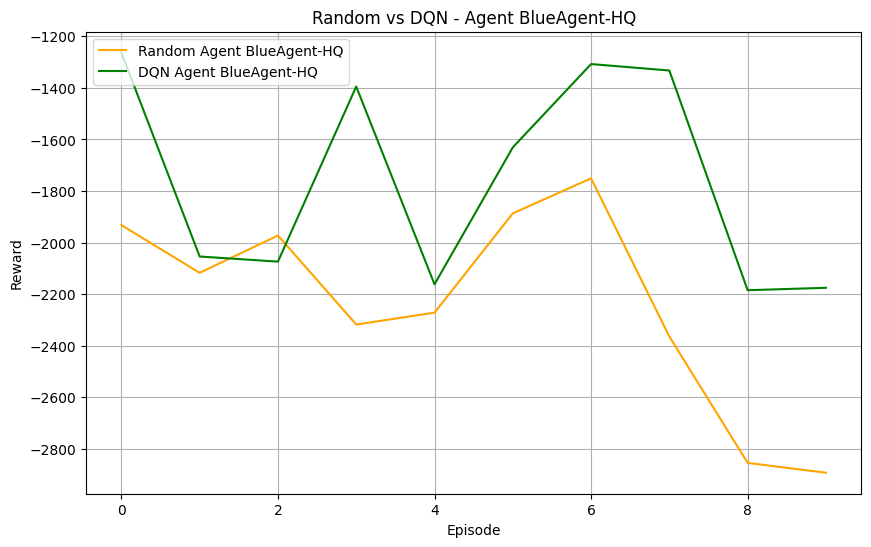

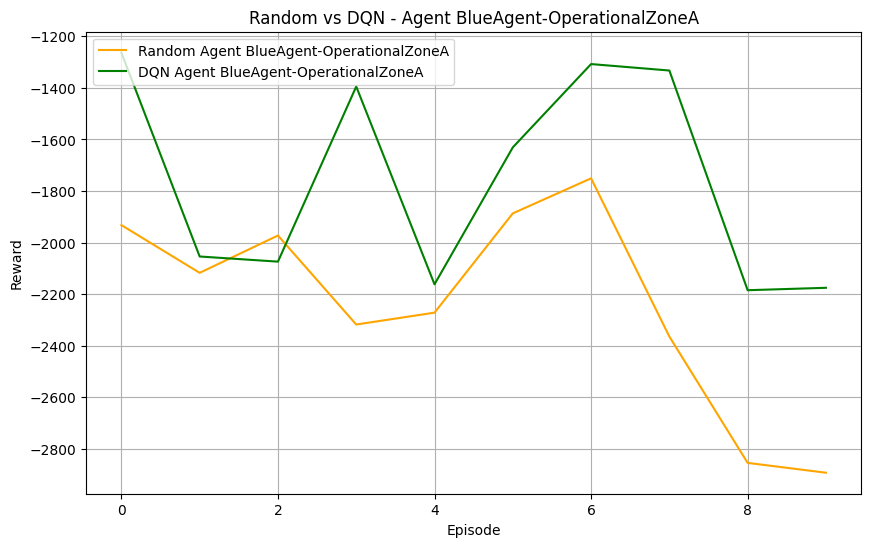

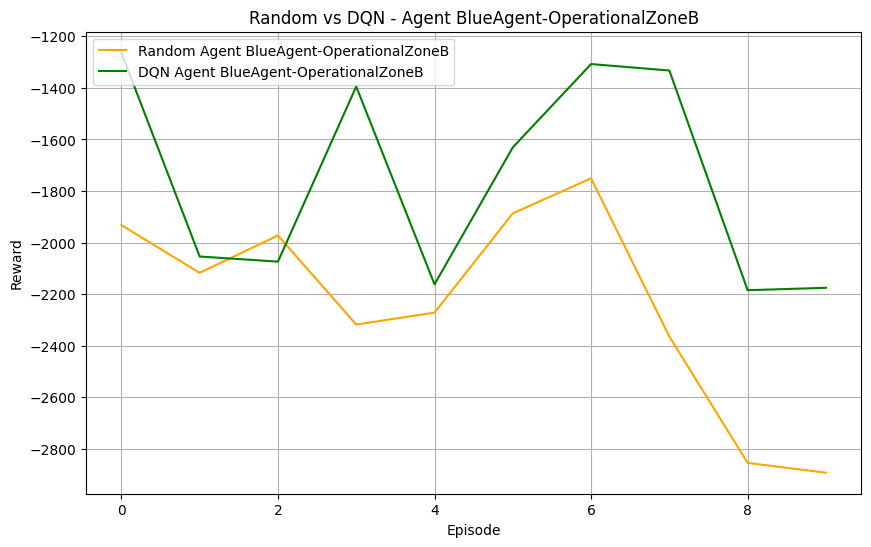

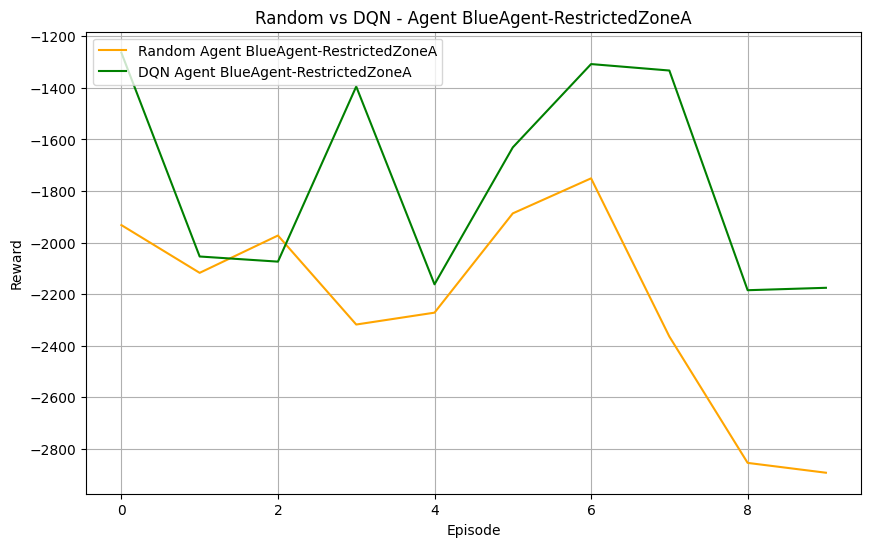

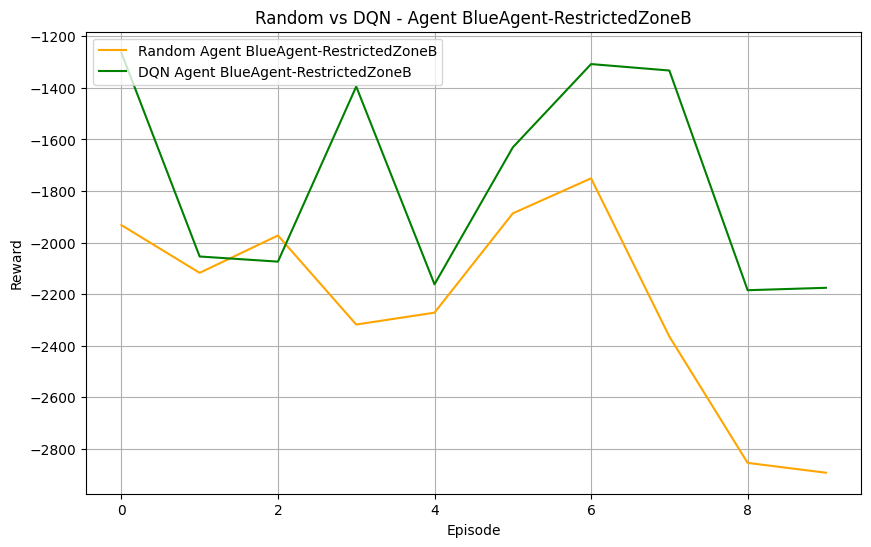

In [5]:
num_test_episodes = 10
random_step_rewards_list = []
dqn_step_rewards_list = []
random_rewards_dict = {agent: [] for agent in agents}
trained_rewards_dqn_dict = {agent: [] for agent in agents}

# Define action type groups
non_zero_trust_types = [MONITOR, REBOOT]
zero_trust_types = [DEPLOY_DECOY, ENABLE_AC, DISABLE_AC, ENABLE_SUBNET_AC, DISABLE_SUBNET_AC]

env = env_creator({"debug": False, "security_risk": 0.05, "success_rate": 0.9, "step_threshold": 100})

for episode in tqdm(range(num_test_episodes), desc="Evaluating DQN vs Random"):
    # Running one episode with the random policy
    random_episode_rewards, _, random_steps = run_random_policy(env, agents)
    # Running one episode with the trained DQN policy
    dqn_episode_rewards, episode_actions, dqn_steps = run_episode_dqn(env, algo, agents, POLICY_MAP)
    
    random_step_rewards_list.append(random_steps)
    dqn_step_rewards_list.append(dqn_steps)
    
    for agent in agents:
        random_rewards_dict[agent].append(random_episode_rewards[agent])
        trained_rewards_dqn_dict[agent].append(dqn_episode_rewards[agent])

# Plotting reward comparisons per agent
for agent in agents:
    plt.figure(figsize=(10, 6))
    plt.plot(random_rewards_dict[agent], label=f"Random Agent {agent}", color='orange')
    plt.plot(trained_rewards_dqn_dict[agent], label=f"DQN Agent {agent}", color='green')
    plt.legend(loc='upper left')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Random vs DQN - Agent {agent}')
    plt.grid(True)
    plt.savefig(f'Comparison_{agent}_DQN_vs_Random.jpg', dpi=150, bbox_inches='tight')
    plt.show()


In [6]:
algo.stop()
ray.shutdown()